In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import copy
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn import svm,preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

#Handle annoying warnings
import warnings, sklearn.exceptions
#warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning

Global Parameters

In [ ]:
target_idx=199                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV
norm_target=0                                       #Normalize target switch
norm_features=1                                     #Normalize target switch
binning=1                                           #Control Switch for Bin Target
bin_cnt=2                                           #If bin target, this sets number of classes
feat_select=1                                       #Control Switch for Feature Selection
fs_type=  1                                         #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=0                                       #Start column of features
k_cnt=2                                             #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3

#Set global model parameters
rand_st=0                                           #Set Random State variable for randomizing splits on runs


Load Data

In [ ]:
file1= csv.reader(open('/content/drive/My Drive/Programming machine Learning/cleaned.csv'), delimiter=',', quotechar='"')

#Read Header Line
header=next(file1) 
header           

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append((row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)-2):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append((row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
# =============================================================================
# header[0]
# print(header)
# print(len(target),len(data))
# for i in range(10):
#     print(target[i])
#     print(data[i])
# print('\n')
# 
# =============================================================================
data_np=np.asarray(data)
target_np=np.asarray(target)

data_np.astype(np.float64)
target_np.astype(np.float64)


array([1., 1., 1., ..., 0., 0., 1.])

Wrapper Feat Select Helper

In [ ]:
#Recursive Function for searching thru feature space
def feat_space_search(arr, curr_idx):
    '''Setup currently as exhuastive search, but could be changed to use
       greedy search, random search, genetic algorithms, etc. ... also
       no regularization, so probably selects more features than necessary'''
    global roll_idx, combo_ctr, best_score, sel_idx
    
    if curr_idx==feat_cnt:
        #If end of feature array, roll thru combinations
        roll_idx=roll_idx+1
        print ("Combos Searched so far:", combo_ctr, "Current Best Score:", best_score)
        for i in range(roll_idx, len(arr)):
            arr[i]=0
        if roll_idx<feat_cnt-1:
            feat_space_search(arr, roll_idx+1)                                                                      #Recurse till end of rolls
        
    else:
        #Else setup next feature combination and calc performance
        arr[curr_idx]=1
        data=data_np#_wrap                                                                                          #Temp array to hold data
        temp_del=[i for i in range(len(arr)) if arr[i]==0]                                                          #Pick out features not in this combo, and remove
        data = np.delete(data, temp_del, axis=1)
        data_train, data_test, target_train, target_test = train_test_split(data, target_np, test_size=0.35)                

        if binning==1:
            if bin_cnt<=2:
                scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
                scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5) 
                score = scores['test_roc_auc'].mean()                                                               #AUC
            else:
                scorers = {'Accuracy': 'accuracy'}
                scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5) 
                score = scores['test_Accuracy'].mean()                                                              #Accuracy
            print('Random Forest Acc/AUC:', curr_idx, feat_arr, len(data[0]), score)
            if score>best_score:                                                                                    #Compare performance and update sel_idx and best_score, if needed
                best_score=score
                sel_idx=copy.deepcopy(arr) 
                
        if binning==0:
            scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'}
            scores = cross_validate(rgr, data, target_np, scoring=scorers, cv=5)    
            score = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']]).mean()                              #RMSE
            print('Random Forest RMSE:', curr_idx, feat_arr, len(data[0]), score)
            if score<best_score:                                                                                    #Compare performance and update sel_idx and best_score, if needed
                best_score=score
                sel_idx=copy.deepcopy(arr) 

        #move to next feature index and recurse
        combo_ctr+=1  
        curr_idx+=1
        feat_space_search(arr, curr_idx)  

Data Preprocessing

In [ ]:
if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

'''if binning==1:
    #Discretize Target variable with KBinsDiscretizer
    enc = KBinsDiscretizer(n_bins=[bin_cnt], encode='ordinal', strategy='quantile')                         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"
    target_np_bin = enc.fit_transform(target_np.reshape(-1,1))

    #Get Bin min/max
    temp=[[] for x in range(bin_cnt+1)]
    for i in range(len(target_np)):
        for j in range(bin_cnt):
            if target_np_bin[i]==j:
                temp[j].append(target_np[i])

    for j in range(bin_cnt):
        print('Bin', j, ':', min(temp[j]), max(temp[j]), len(temp[j]))
    print('\n')

    #Convert Target array back to correct shape
    target_np=np.ravel(target_np_bin)'''


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


'if binning==1:\n    #Discretize Target variable with KBinsDiscretizer\n    enc = KBinsDiscretizer(n_bins=[bin_cnt], encode=\'ordinal\', strategy=\'quantile\')                         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"\n    target_np_bin = enc.fit_transform(target_np.reshape(-1,1))\n\n    #Get Bin min/max\n    temp=[[] for x in range(bin_cnt+1)]\n    for i in range(len(target_np)):\n        for j in range(bin_cnt):\n            if target_np_bin[i]==j:\n                temp[j].append(target_np[i])\n\n    for j in range(bin_cnt):\n        print(\'Bin\', j, \':\', min(temp[j]), max(temp[j]), len(temp[j]))\n    print(\'\n\')\n\n    #Convert Target array back to correct shape\n    target_np=np.ravel(target_np_bin)'

Feature Selection

In [ ]:
#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=1)                                      #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
            sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if binning==1:
            clf = svm.SVC(kernel = 'linear',gamma = 'scale',C = 1.0, probability = True, random_state = rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select: ')
        if binning==0:
            rgr = '''Unused in this homework'''
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:
        if binning==0:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(chi2, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
            print ('Univariate Feature Selection - Chi2: ')
            sel_idx=fit_mod.get_support()

        if binning==1:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_classif, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)-2):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')
    
    if fs_type==4:
        #Full-blown Wrapper Select (from any kind of ML model)        
        if binning==1:                                                              ######Only work if the Target is binned###########
            start_ts=time.time()
            sel_idx=[]                                                                                      #Empty array to hold optimal selected feature set
            best_score=0                                                                                    #For classification compare Accuracy or AUC, higher is better, so start with 0
            feat_cnt=len(data_np[0])
            #Create Wrapper model
            clf = svm.SVC(kernel = 'linear',gamma = 0.1, C = 1.0)                                 #This could be any kind of classifier model
      
        if binning==0:                                                              ######Only work if the Target is continuous###########
            start_ts=time.time()
            sel_idx=[]                                                                                      #Empty array to hold optimal selected feature set
            best_score=sys.float_info.max                                                                   #For regression compare RMSE, lower is better, so start with max sys float value
            feat_cnt=len(data_np[0])
            #Create Wrapper model
            rgr = svm.SVR(kernel = 'linear',gamma = 0.1, C = 1.0)                    #This could be any kind of regressor model         
        
        #Loop thru feature sets
        roll_idx=0
        combo_ctr=0
        feat_arr=[0 for col in range(feat_cnt)]                                         #Initialize feature array
        for idx in range(feat_cnt):
            roll_idx=idx
            feat_space_search(feat_arr, idx)                                           #Recurse
            feat_arr=[0 for col in range(feat_cnt)]                                     #Reset feature array after each iteration
        
        print('# of Feature Combos Tested:', combo_ctr)
        print(best_score, sel_idx, len(data_np[0]))
        print("Wrapper Feat Sel Runtime:", time.time()-start_ts)

    if fs_type ==5:
      print("L2 Regularization")
      sel = SelectFromModel(LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear'))
      sel.fit(data_np, target_np)
      sel_idx = sel.get_support()

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected', temp)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)


--FEATURE SELECTION ON-- 

Stepwise Recursive Backwards - Random Forest: 
[10  3 10 10  8  7  8 12  7  4  3  4  4  3  5  5  9  8  4  7  2 10  8  3
  4 11  8  3  8  7 12  7  8 10 11 12  2  2  9 12  4 11 10 12  3  3  9  5
  5  7  6  5  3  6  7  8  8 12  9  4  7  5 12  6 11  5  9  9  4  9  5  4
 11  3  3  5 11  4  3 11 12  6 12 10  9  4  6 10 12 10  8 12  5  7  5  6
  5 12 11 10 12  9 11 11  9  6  7  9  6  6  9  5 11  6  5  9 10  1  8  8
  6  6  3  6  9  3  9  7  3  3 11  6  7  7  7  4  6  1  8 11 11  4  8 11
  5 12 11  8 10 10 10  8 11 12 10  4  6  3  2  5  2 11 10 12  8 10 12  7
  8 12  9  9  3  6  4  5  8  7  4  2  4  5  6  5  9 11  9 10  7  4  7 12
  6 10  3  4  7  3]
Selected ['Net Income per Share', 'Earnings Yield']
Features (total/selected): 198 2




Train SciKit Models

In [ ]:
print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

####Classifiers####
if binning==1 and cross_val==0:
    #SciKit
    '''Test/Train split unused in this homework, skip down to CV section'''
 

                                                                                                                         
 
####Cross-Val Classifiers####
if binning==1 and cross_val==1:
    print(data_train)
    print(target_train)
    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                
    
    #SciKit SVM - Cross Val
    start_ts=time.time()
    clf= svm.SVC(kernel = 'rbf',gamma = 'scale',C = 1.0, probability = True, random_state = rand_st)
    scores= cross_validate(clf,data_np.astype(np.float),target_np.astype(np.float),scoring = scorers,cv =5)

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("SVM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("SVM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)






--ML Model Output-- 

[[-0.45927171  0.00469695]
 [-0.39416337  0.12434935]
 [-0.2895851   0.2766605 ]
 ...
 [ 1.40050173  0.83844876]
 [-0.28371579  0.29689158]
 [-0.04191408  0.51423121]]
['1' '1' '1' ... '1' '1' '1']
SVM Acc: 0.72 (+/- 0.03)
SVM AUC: 0.67 (+/- 0.07)
CV Runtime: 10.486029148101807


Network Boundary

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Text(0.5, 1.0, 'Neural Network Region Boundary')

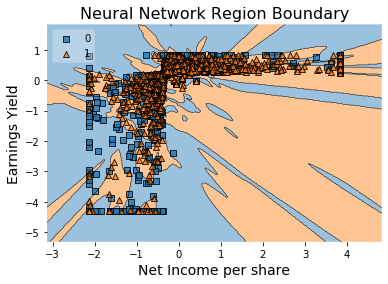

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
#clf1= svm.SVC(kernel = 'rbf',gamma = 'auto',C = 0.5, probability = False, random_state = rand_st).fit(data_train.astype(np.float),target_train.astype(np.integer))

#clf1 = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st).fit(data_train.astype(np.float),target_train.astype(np.integer))
#clf1 = RandomForestClassifier(n_estimators=2, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st).fit(data_train.astype(np.float),target_train.astype(np.integer))
#clf1 = LogisticRegression(max_iter=250, solver = 'liblinear').fit(data_train.astype(np.float),target_train.astype(np.integer))
#clf1=AdaBoostClassifier(n_estimators=100, base_estimator = None,learning_rate=0.1,random_state = rand_st).fit(data_train.astype(np.float),target_train.astype(np.integer))
#clf1=GradientBoostingClassifier(loss = "deviance",n_estimators=100,learning_rate=0.1,max_depth=3,min_samples_split=3,random_state = rand_st).fit(data_train.astype(np.float),target_train.astype(np.integer))
X_scaled = preprocessing.scale(data_train)
clf1=MLPClassifier(activation= "logistic",solver = "lbfgs",alpha = 0.0001, max_iter = 10000,hidden_layer_sizes=(200,200),random_state = rand_st).fit(X_scaled.astype(np.float),target_train.astype(np.integer))

plot_decision_regions(X=data_train.astype(np.float), 
                      y=target_train.astype(np.integer),
                      clf=clf1,
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel('Net Income per share',size=14)
plt.ylabel('Earnings Yield',size=14)
plt.title('Neural Network Region Boundary', size=16)